In [67]:
import numpy as np
import pandas as pd
import mat73

filePath = '/Users/inseungkang/Documents/GRF Estimation Data/'
fileName = 'combinedWalkingData.mat'
data = mat73.loadmat(filePath+fileName)

In [69]:
import matplotlib.pyplot as plt
# Model Input
gryo_foot_x_l = np.expand_dims(np.transpose(data['NRH09']['S125_C']['SegP']['P']['suit_gyro_x_foot_p']['x']), axis=1)
gryo_foot_y_l = np.expand_dims(np.transpose(data['NRH09']['S125_C']['SegP']['P']['suit_gyro_y_foot_p']['x']), axis=1)
gryo_foot_z_l = np.expand_dims(np.transpose(data['NRH09']['S125_C']['SegP']['P']['suit_gyro_z_foot_p']['x']), axis=1)
gryo_foot_x_r = np.expand_dims(np.transpose(data['NRH09']['S125_C']['SegP']['P']['suit_gyro_x_foot_np']['x']), axis=1)
gryo_foot_y_r = np.expand_dims(np.transpose(data['NRH09']['S125_C']['SegP']['P']['suit_gyro_y_foot_np']['x']), axis=1)
gryo_foot_z_r = np.expand_dims(np.transpose(data['NRH09']['S125_C']['SegP']['P']['suit_gyro_z_foot_np']['x']), axis=1)

acc_foot_x_l = np.expand_dims(np.transpose(data['NRH09']['S125_C']['SegP']['P']['suit_acc_loc_x_foot_p']['x']), axis=1)
acc_foot_y_l = np.expand_dims(np.transpose(data['NRH09']['S125_C']['SegP']['P']['suit_acc_loc_y_foot_p']['x']), axis=1)
acc_foot_z_l = np.expand_dims(np.transpose(data['NRH09']['S125_C']['SegP']['P']['suit_acc_loc_z_foot_p']['x']), axis=1)
acc_foot_x_l = np.expand_dims(np.transpose(data['NRH09']['S125_C']['SegP']['P']['suit_acc_loc_x_foot_np']['x']), axis=1)
acc_foot_y_r = np.expand_dims(np.transpose(data['NRH09']['S125_C']['SegP']['P']['suit_acc_loc_y_foot_np']['x']), axis=1)
acc_foot_z_r = np.expand_dims(np.transpose(data['NRH09']['S125_C']['SegP']['P']['suit_acc_loc_z_foot_np']['x']), axis=1)

# Ground Truth
GRF_x = np.expand_dims(np.transpose(data['NRH09']['S125_C']['SegP']['P']['GRF']['x']), axis=1)
GRF_y = np.expand_dims(np.transpose(data['NRH09']['S125_C']['SegP']['P']['GRF']['y']), axis=1)
GRF_z = np.expand_dims(np.transpose(data['NRH09']['S125_C']['SegP']['P']['GRF']['z']), axis=1)

print(gryo_foot_x_l.shape)

(47, 1, 1001)


In [79]:
#getting data into X, Y shape
train_x = np.concatenate((gryo_foot_x_l, gryo_foot_y_l, gryo_foot_z_l,
                            acc_foot_x_l, acc_foot_y_l, acc_foot_z_l), axis=1)
train_y = np.concatenate((GRF_x, GRF_y, GRF_z), axis=1)

from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.2)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

import torch
from torch.utils.data import Dataset
class dataSet(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.Tensor(x_data)
        self.y_data = torch.Tensor(x_data)
        self.len = self.x_data.shape[0]

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

    def __len__(self):
        return self.len

train_data = dataSet(train_x, train_y)
val_data = dataSet(val_x, val_y)

batch_size = 3
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
        nn.Conv1d(in_channels=6,out_channels=6,kernel_size=10,stride=1),
        nn.ReLU(),
        nn.Dropout1d(0.2)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(6,6),                                              
            nn.ReLU(),
            nn.Linear(6,6)                                 
        )  

    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out


In [458]:
from tkinter.tix import Y_REGION
from torch.optim.lr_scheduler import CosineAnnealingLR,StepLR,ReduceLROnPlateau
import torch.nn.functional as F
import numpy as np
import math

train_preds = np.zeros((int(train_x.shape[0]*train_x.shape[1])))
val_preds = np.zeros((int(val_x.shape[0]*val_x.shape[1])))
train_targets = np.zeros((int(train_x.shape[0]*train_x.shape[1])))

class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.network = torch.nn.Sequential(
            torch.nn.Conv1d(6, 10, 10, stride=1),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(992, 1001),
        )


    def forward(self, x):
        x = self.network(x)
        return x
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(6,10,10,stride=1)
        # self.conv2 = nn.Conv1d(3, 20, 5)
        # self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(9920, 50)
        self.fc2 = nn.Linear(50, 1, 1001)
    def forward(self,input):
        x = F.relu(self.conv1(input))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


class testNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.network = torch.nn.Sequential(
        torch.nn.Conv1d(6,6,5,stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv1d(6,6,5,stride=1),
        torch.nn.Flatten(),
        torch.nn.Linear(5958, 600)
        )

    def forward(self, x):
        x = self.network(x)
        return x

tensor_train_x = torch.tensor(train_x[:,:,:]).float()
tensor_train_y = torch.tensor(train_y[:,2,:600]).float().unsqueeze(1)
print(tensor_train_x.shape)
print(tensor_train_y.shape)

model = testNN()
learning_rate = 0.001
num_epoch = 2000
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()
import time

loss_result = []
model.train()
# device = "cuda" if torch.cuda.is_available() else "cpu"
# X, y = tensor_train_x.to(device), tensor_train_y.to(device)

for epoch in range(1, num_epoch+1):
    start_time = time.time()

    y_pred = model(tensor_train_x)
    # print(y_pred.shape)
    loss = loss_fn(y_pred, tensor_train_y)
    loss_result.append(loss.detach().numpy())

    model.zero_grad()
    loss.backward()
    optimizer.step()

    output = (output>0.5).float()
    correct = (output == labels).float().sum()
    print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch,num_epoch, loss.data[0], correct/x.shape[0]))

plt.plot(loss_result)




torch.Size([37, 6, 1001])
torch.Size([37, 1, 600])


KeyboardInterrupt: 

torch.Size([1, 6, 1001])


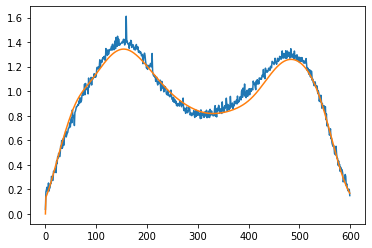

In [449]:
testx = torch.tensor(train_x[0,:,:]).float().unsqueeze(0)
testy = torch.tensor(train_y[0,2,:600]).float().unsqueeze(1)
print(testx.shape)
model.eval()
testy_pred=model(testx)
plt.plot(testy_pred[0,:].detach().numpy())
plt.plot(testy)


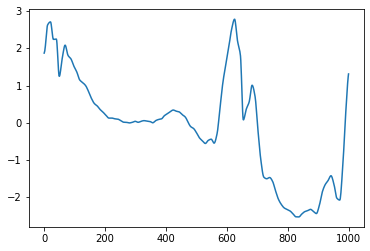

In [283]:
model.eval()
test = model(tensor_val_x[0,:,:].unsqueeze(0))
plt.plot(tensor_val_x[0,0,:])
# print(tensor_val_x[0,:,:].unsqueeze(0).shape)
# print(test)
# plt.plot(test.detach().numpy())
# plt.plot(tensor_val_y[0,:])
# plt.plot(tensor_val_y[1,:])
# plt.plot(tensor_val_y[2,:])



In [84]:
import time
import os
import torch
import csv
from torch.utils.tensorboard import SummaryWriter

class Train:
    def __init__(self, **kwargs):

        self.result_path = kwargs['result_path']
        self.tensorboard_path = os.path.join(self.result_path, 'tensorboard')
        
        self.log_path = os.path.join(self.result_path, 'log_%d.csv'%kwargs['fold_idx'])
        if os.path.isfile(self.log_path):
            os.remove(self.log_path)
        self.tb_writer = SummaryWriter(log_dir=self.tensorboard_path)

        self.device = kwargs['device']
        self.model = kwargs['model']
        self.optimizer = kwargs['optimizer']
        self.criterion = kwargs['criterion']
        self.task = kwargs['task']
        self.fold_idx = kwargs['fold_idx']
        self.epochs = kwargs['epochs']
        self.batch_size = kwargs['batch_size']
        self.period = kwargs['period']
        self.train_data_loader = kwargs['train_data_loader']
        self.val_data_loader = kwargs['val_data_loader']
        self.scheduler = kwargs['scheduler']
        self.is_plateau = kwargs['is_plateau']

        self.loss = {}

        self.rmse = {}
        self.accuracy = {}
        self.precision = {}
        self.recall = {}
        self.specificity = {}
        self.npv = {}
        self.f1score = {}

    def log_regression(self, output, target, _mode):
        _rmse = metric.gait_phase_rmse(output=output, target=target)
        self.rmse[_mode] += _rmse

    def log(self, output, target, _mode):
        if self.task == 'regression':
           self.log_regression(output, target, _mode)
        
    def write_regression(self, epoch):
        self.tb_writer.add_scalars('rmse_%d'%self.fold_idx, self.rmse, epoch)
    
    def write(self, epoch, end_time):
        self.tb_writer.add_scalars('loss_%d'%self.fold_idx, self.loss, epoch)
        if self.task == 'regression':
            print('Epoch: %d | Loss: %1.5f | RMSE: %1.5f | Elapsed Time: %0f'%(epoch, self.loss['val'], self.rmse['val'], end_time))
            with open(self.log_path, 'a', newline='') as f:
                csv_writer = csv.DictWriter(f, fieldnames=['loss', 'val_loss', 'rmse', 'val_rmse'])
                csv_writer.writerow({'loss': self.loss['train'], 'rmse': self.rmse['train'],
                                    'val_loss': self.loss['val'], 'val_rmse': self.rmse['val']})
            self.write_regression(epoch)

    def on_epoch_validation(self):
        self.model.eval()
        with torch.no_grad():
            for _, (x, y) in enumerate(self.val_data_loader):
                x = x.to(self.device)
                y = y.to(self.device)

                if x.size(0) == self.batch_size:
                    output = self.model(x)
                    self.log(output, y, 'val')
                    
                    if isinstance(self.criterion, dict) and isinstance(output, tuple):
                    
                        out_r, out_c = output

                        regression_criterion = self.criterion['regression']
                        regression_loss = regression_criterion(out_r, y[:, :-1])
                        classification_criterion = self.criterion['classification']
                        classification_loss = classification_criterion(out_c.squeeze(), y[:, -1])

                        _loss = regression_loss + classification_loss
                        self.loss['val'] += _loss.item()
                    
                    else:
                        _loss = self.criterion(output, y)
                        self.loss['val'] += _loss.item()

    def on_epoch_train(self):
        self.model.train()
        self.optimizer.zero_grad()
        for _, (x, y) in enumerate(self.train_data_loader):
            x = x.to(self.device)
            y = y.to(self.device)

            if x.size(0) == self.batch_size:
                output = self.model(x)
                self.log(output, y, 'train')

                if isinstance(self.criterion, dict) and isinstance(output, tuple):
                    
                    out_r, out_c = output

                    #########################################################
                    # preventing the model from training swing phase
                    # mask = torch.stack([y[:, -1], y[:, -1]], dim=1)
                    # out_r.register_hook(lambda grad: grad * mask)
                    #########################################################

                    regression_criterion = self.criterion['regression']
                    regression_loss = regression_criterion(out_r, y[:, :-1])
                    
                    classification_criterion = self.criterion['classification']
                    classification_loss = classification_criterion(out_c.squeeze(), y[:, -1])
                    
                    self.optimizer.zero_grad()
                    regression_loss.backward(retain_graph=True)
                    classification_loss.backward(retain_graph=True)

                    self.optimizer.step()
                    self.loss['train'] += regression_loss.item() + classification_loss.item()

                else:
                    _loss = self.criterion(output, y)
                    self.optimizer.zero_grad()
                    _loss.backward()
                    self.optimizer.step()
                    self.loss['train'] += _loss.item()

    def do(self):
        print('K-fold: %d'%self.fold_idx)
        tb_writer = SummaryWriter(log_dir=self.tensorboard_path)
        
        best_val_loss = float('inf')
        for epoch in range(1, self.epochs + 1):
            
            for metric in [self.loss, self.rmse, self.accuracy, self.precision, self.recall, self.specificity, self.npv, self.f1score]:
                metric['train'] = 0
                metric['val'] = 0
            
            start_time = time.time()
            self.on_epoch_train()
            self.on_epoch_validation()
            end_time = time.time() - start_time

            for metric in [self.loss, self.rmse, self.accuracy, self.precision, self.recall, self.specificity, self.npv, self.f1score]:
                metric['train'] = metric['train'] / len(self.train_data_loader)
                metric['val'] = metric['val'] / len(self.val_data_loader)

            self.write(epoch, end_time)
            
            # saving the model
            if epoch % self.period == 0:
                model_path = os.path.join(self.result_path, 'model_%d_%d.pt'%(self.fold_idx, epoch))
                torch.save(self.model, model_path)
            if  self.loss['val'] < best_val_loss:
                model_path = os.path.join(self.result_path, 'model_%d_best.pt'%(self.fold_idx))
                torch.save(self.model, model_path)
                print('Current Validation Loss: %1.5f | New validation Loss: %1.5f'%(best_val_loss, self.loss['val']))
                best_val_loss = self.loss['val']
        
            if self.is_plateau:
                self.scheduler.step(best_val_loss)
            else:
                self.scheduler.step()

        tb_writer.close()

ModuleNotFoundError: No module named 'metric'

In [155]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
        nn.Conv1d(6,6,10,stride=1),
        nn.ReLU(),
        nn.Dropout1d(0.2)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(6,6),                                              
            nn.ReLU(),
            nn.Linear(6,6)                                 
        )  

    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out


        

In [114]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 10

model = CNN()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss_arr =[]
# for i in range(num_epoch):
#     for j,[image,label] in enumerate(train_loader):
#         x = image.to(device)
#         y= label.to(device)
        
#         optimizer.zero_grad()
        
#         output = model.forward(x)
        
#         loss = loss_func(output,y)
#         loss.backward()
#         optimizer.step()
        
#         if j % 1000 == 0:
#             print(loss)
#             loss_arr.append(loss.cpu().detach().numpy())


In [82]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch

df_train = pd.read_csv('/Users/inseungkang/Documents/GRF Estimation Data/train.csv')
df_test = pd.read_csv('/Users/inseungkang/Documents/GRF Estimation Data/test.csv')

# I don't use "time" feature
train_input = df_train["signal"].values.reshape(-1,4000,1)#number_of_data:1250 x time_step:4000
train_input_mean = train_input.mean()
train_input_sigma = train_input.std()
train_input = (train_input-train_input_mean)/train_input_sigma
test_input = df_test["signal"].values.reshape(-1,10000,1)
test_input = (test_input-train_input_mean)/train_input_sigma

train_target = pd.get_dummies(df_train["open_channels"]).values.reshape(-1,4000,11)#classification

idx = np.arange(train_input.shape[0])
train_idx, val_idx = train_test_split(idx, random_state = 111,test_size = 0.2)

val_input = train_input[val_idx]
train_input = train_input[train_idx] 
val_target = train_target[val_idx]
train_target = train_target[train_idx] 

print("train_input:{}, val_input:{}, train_target:{}, val_target:{}".format(train_input.shape, val_input.shape, train_target.shape, val_target.shape))

class conbr_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, stride, dilation):
        super(conbr_block, self).__init__()

        self.conv1 = nn.Conv1d(in_layer, out_layer, kernel_size=kernel_size, stride=stride, dilation = dilation, padding = 3, bias=True)
        self.bn = nn.BatchNorm1d(out_layer)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn(x)
        out = self.relu(x)
        
        return out      

train_input:(1000, 4000, 1), val_input:(250, 4000, 1), train_target:(1000, 4000, 11), val_target:(250, 4000, 11)


In [62]:
from torch.utils.data import Dataset
class ION_Dataset(Dataset):
    def __init__(self, train_input, train_output,mode='train'):
        self.train_input = train_input
        self.train_output = train_output
        self.mode = mode
        
    def __len__(self):
        return len(self.train_input)
    
    def _augmentations(self,input_data, target_data):
        #flip
        if np.random.rand()<0.5:    
            input_data = input_data[::-1]
            target_data = target_data[::-1]
        return input_data, target_data
    
    def __getitem__(self, idx):
        x = self.train_input[idx]
        y = self.train_output[idx]
        if self.mode =='train':
            x,y = self._augmentations(x,y)
        out_x = torch.tensor(np.transpose(x.copy(),(1,0)), dtype=torch.float)
        out_y = torch.tensor(np.transpose(y.copy(),(1,0)), dtype=torch.float)
        return out_x, out_y



In [63]:
batch_size = 8
train = ION_Dataset(train_input, train_target,mode='train')
valid = ION_Dataset(val_input, val_target,mode='valid')

x_test = torch.tensor(np.transpose(test_input,(0,2,1)), dtype=torch.float)
test = torch.utils.data.TensorDataset(x_test)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)


In [53]:
class UNET_1D(nn.Module):
    def __init__(self ,input_dim,layer_n,kernel_size,depth):
        super(UNET_1D, self).__init__()
        self.input_dim = input_dim
        self.layer_n = layer_n
        self.kernel_size = kernel_size
        self.depth = depth
        
        self.AvgPool1D1 = nn.AvgPool1d(input_dim, stride=5)
        self.AvgPool1D2 = nn.AvgPool1d(input_dim, stride=25)
        self.AvgPool1D3 = nn.AvgPool1d(input_dim, stride=125)
        
        self.layer1 = self.down_layer(self.input_dim, self.layer_n, self.kernel_size,1, 2)
        self.layer2 = self.down_layer(self.layer_n, int(self.layer_n*2), self.kernel_size,5, 2)
        self.layer3 = self.down_layer(int(self.layer_n*2)+int(self.input_dim), int(self.layer_n*3), self.kernel_size,5, 2)
        self.layer4 = self.down_layer(int(self.layer_n*3)+int(self.input_dim), int(self.layer_n*4), self.kernel_size,5, 2)
        self.layer5 = self.down_layer(int(self.layer_n*4)+int(self.input_dim), int(self.layer_n*5), self.kernel_size,4, 2)

        self.cbr_up1 = conbr_block(int(self.layer_n*7), int(self.layer_n*3), self.kernel_size, 1, 1)
        self.cbr_up2 = conbr_block(int(self.layer_n*5), int(self.layer_n*2), self.kernel_size, 1, 1)
        self.cbr_up3 = conbr_block(int(self.layer_n*3), self.layer_n, self.kernel_size, 1, 1)
        self.upsample = nn.Upsample(scale_factor=5, mode='nearest')
        self.upsample1 = nn.Upsample(scale_factor=5, mode='nearest')
        
        self.outcov = nn.Conv1d(self.layer_n, 11, kernel_size=self.kernel_size, stride=1,padding = 3)
    
        
    def down_layer(self, input_layer, out_layer, kernel, stride, depth):
        block = []
        block.append(conbr_block(input_layer, out_layer, kernel, stride, 1))
        for i in range(depth):
            block.append(re_block(out_layer,out_layer,kernel,1))
        return nn.Sequential(*block)
            
    def forward(self, x):
        
        pool_x1 = self.AvgPool1D1(x)
        pool_x2 = self.AvgPool1D2(x)
        pool_x3 = self.AvgPool1D3(x)
        
        #############Encoder#####################
        
        out_0 = self.layer1(x)
        out_1 = self.layer2(out_0)
        
        x = torch.cat([out_1,pool_x1],1)
        out_2 = self.layer3(x)
        
        x = torch.cat([out_2,pool_x2],1)
        x = self.layer4(x)
        
        #############Decoder####################
        
        up = self.upsample1(x)
        up = torch.cat([up,out_2],1)
        up = self.cbr_up1(up)
        
        up = self.upsample(up)
        up = torch.cat([up,out_1],1)
        up = self.cbr_up2(up)
        
        up = self.upsample(up)
        up = torch.cat([up,out_0],1)
        up = self.cbr_up3(up)
        
        out = self.outcov(up)
        
        #out = nn.functional.softmax(out,dim=2)
        
        return out

In [64]:
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import CosineAnnealingLR,StepLR,ReduceLROnPlateau
import time

n_epochs = 100
lr = 0.001

## Build tensor data for torch
train_preds = np.zeros((int(train_input.shape[0]*train_input.shape[1])))
val_preds = np.zeros((int(val_input.shape[0]*val_input.shape[1])))

train_targets = np.zeros((int(train_input.shape[0]*train_input.shape[1])))

avg_losses_f = []
avg_val_losses_f = []

##Loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

#Build model, initial weight and optimizer
model = conbr_block(1,128,7,3,1) #(input_dim, hidden_layer, kernel_size, depth)
optimizer = torch.optim.Adam(model.parameters(), lr = lr,weight_decay=1e-5) # Using Adam optimizer
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.8, min_lr=1e-8) # Using ReduceLROnPlateau schedule
temp_val_loss = 9999999999

In [65]:
for epoch in range(n_epochs):
    
    start_time = time.time()
    model.train()
    avg_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        avg_loss += loss.item()/len(train_loader)

        pred = F.softmax(y_pred, 1).detach().cpu().numpy().argmax(axis=1)
        train_preds[i * batch_size*train_input.shape[1]:(i+1) * batch_size*train_input.shape[1]] = pred.reshape((-1))
        train_targets[i * batch_size*train_input.shape[1]:(i+1) * batch_size*train_input.shape[1]] = y_batch.detach().cpu().argmax(axis=1).reshape((-1))
        del y_pred, loss, x_batch, y_batch, pred
        
        
    model.eval()

    avg_val_loss = 0.
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch.cuda()).detach()

        avg_val_loss += loss_fn(y_pred.cpu(), y_batch).item() / len(valid_loader)
        pred = F.softmax(y_pred, 1).detach().cpu().numpy().argmax(axis=1)
        val_preds[i * batch_size*val_input.shape[1]:(i+1) * batch_size*val_input.shape[1]] = pred.reshape((-1))
        del y_pred, x_batch, y_batch, pred
        
    if avg_val_loss<temp_val_loss:
        #print ('checkpoint_save')
        temp_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'ION_train_checkpoint.pt')
        
    train_score = f1_score(train_targets,train_preds,average = 'macro')
    val_score = f1_score(val_target.argmax(axis=2).reshape((-1)),val_preds,average = 'macro')
    
    elapsed_time = time.time() - start_time 
    scheduler.step(avg_val_loss)
    
    print('Epoch {}/{} \t loss={:.4f} \t train_f1={:.4f} \t val_loss={:.4f} \t val_f1={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss,train_score, avg_val_loss,val_score, elapsed_time))

ValueError: Target size (torch.Size([8, 11, 4000])) must be the same as input size (torch.Size([8, 128, 1334]))